# Part II: Road Lane Detection Using Hough Transform

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [3]:
def find_edges(img,th1,th2):
    grayscale = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    denoised = cv2.medianBlur(grayscale,5)
    canny = cv2.Canny(denoised,th1,th2)
    return canny

In [12]:
def roi(img,bl=1,tl=0.5,br=(0.9,1),tr=(0.6,0.45)):
    height,width = img.shape[:2]
    roi_bottom_left = (0, height*bl)  
    roi_top_left = (0, height * tl)
    roi_top_right = (width * tr[0], height * tr[1])
    roi_bottom_right = (width * br[0], height*br[1])
    
    vertices = np.array([[roi_bottom_left, roi_top_left, roi_top_right, roi_bottom_right]], dtype=np.int32)
    mask = np.zeros_like(img)
    cv2.fillPoly(mask, vertices, (255, 255, 255)) 
    roi_img = cv2.bitwise_and(img, mask)
    
    return roi_img

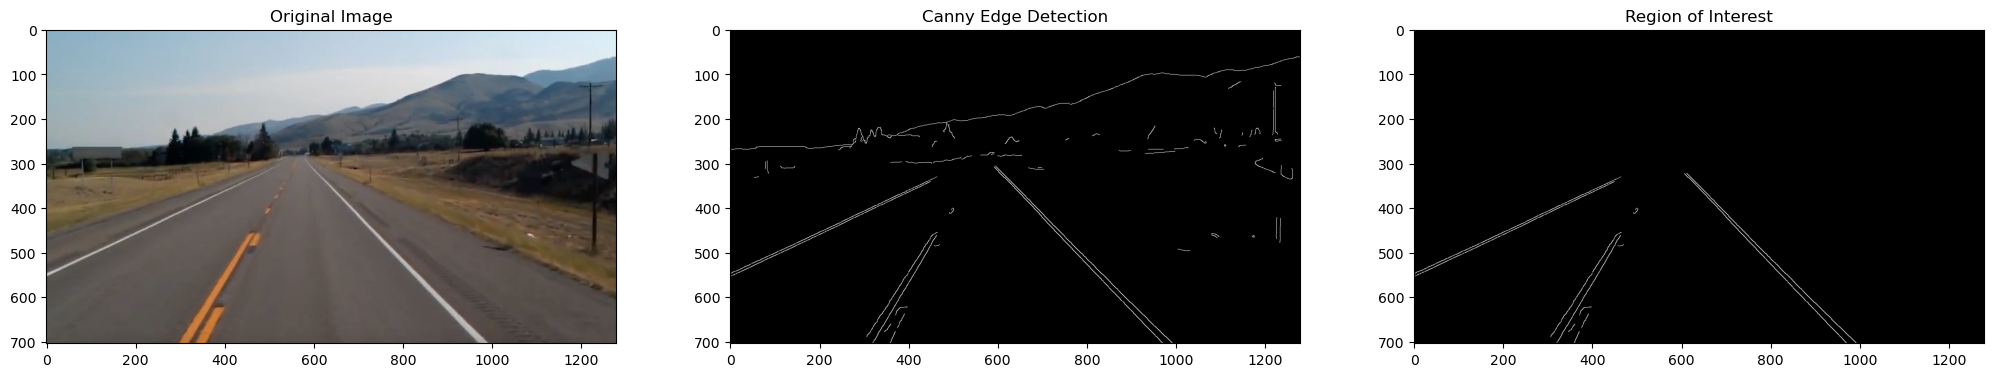

In [13]:
img = cv2.cvtColor(cv2.imread('Lanes/lane_1.jpg'),cv2.COLOR_BGR2RGB)
img1=img.copy()
img2=img.copy()

plt.figure(figsize=(25,10))
plt.subplot(1,3,1)
plt.imshow(img)
plt.title('Original Image')

canny = find_edges(img,100,170)
plt.subplot(1,3,2)
plt.imshow(canny, cmap='gray')
plt.title('Canny Edge Detection')

roi_img = roi(canny)
plt.subplot(1,3,3)
plt.imshow(roi_img, cmap='gray')
plt.title('Region of Interest')
plt.show()

In [14]:
def hough_transform(roi):    
    rho = 1
    theta = np.pi/180
    threshold = 10 # min number of votes
    min_line_len = 80 # min line length to be considered (less than this length will be discarded)
    max_line_gap = 100 # max line gap between lines to be treated as one line

    line_coords = cv2.HoughLinesP(roi, rho, theta, threshold, minLineLength=min_line_len, maxLineGap=max_line_gap)
    polar_params = cv2.HoughLines(roi, rho, theta, threshold)

    return line_coords, polar_params

In [15]:
def non_max_suppression(hough_lines, rho_tolerance, theta_tolerance, max_lines):
    retained_lines = []
    for rho, theta in hough_lines[0]:
        if rho < 0:
            rho *= -1
            theta -= np.pi
        retained_lines.append([rho, theta])

    for polar in hough_lines[1:]:
        rho, theta = polar[0]
        if rho < 0:
            rho *= -1
            theta -= np.pi

        if all(not np.isclose(rho, r, atol=rho_tolerance) or not np.isclose(theta, t, atol=np.radians(theta_tolerance)) for r, t in retained_lines):
            retained_lines.append([rho, theta])
            if len(retained_lines) >= max_lines:
                break

    return retained_lines

In [16]:
line_coords, polar_params = hough_transform(roi_img)
filtered_lines = non_max_suppression(polar_params,30, 5,3)
ht_mask = cv2.cvtColor(roi_img, cv2.COLOR_GRAY2RGB)
mask_lines = np.zeros(img.shape, dtype="uint8")
for line in filtered_lines:
    rho, theta = line
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a * rho
    y0 = b * rho
    
    x1 = int(x0 + 2000 * (-b))  
    y1 = int(y0 + 2000 * (a))
    x2 = int(x0 - 2000 * (-b))
    y2 = int(y0 - 2000 * (a))
    
    cv2.line(mask_lines, (x1,y1), (x2,y2), [0,255,0], 5)

mask_output = cv2.bitwise_and(mask_lines, mask_lines, mask=ht_mask[:,:,-1])
dilated_mask = cv2.dilate(mask_output, (5,5), iterations=5)
overlay = cv2.addWeighted(img2, 1, dilated_mask, 1, 0)


Text(0.5, 1.0, 'Hough Lines with Non Max Suppression')

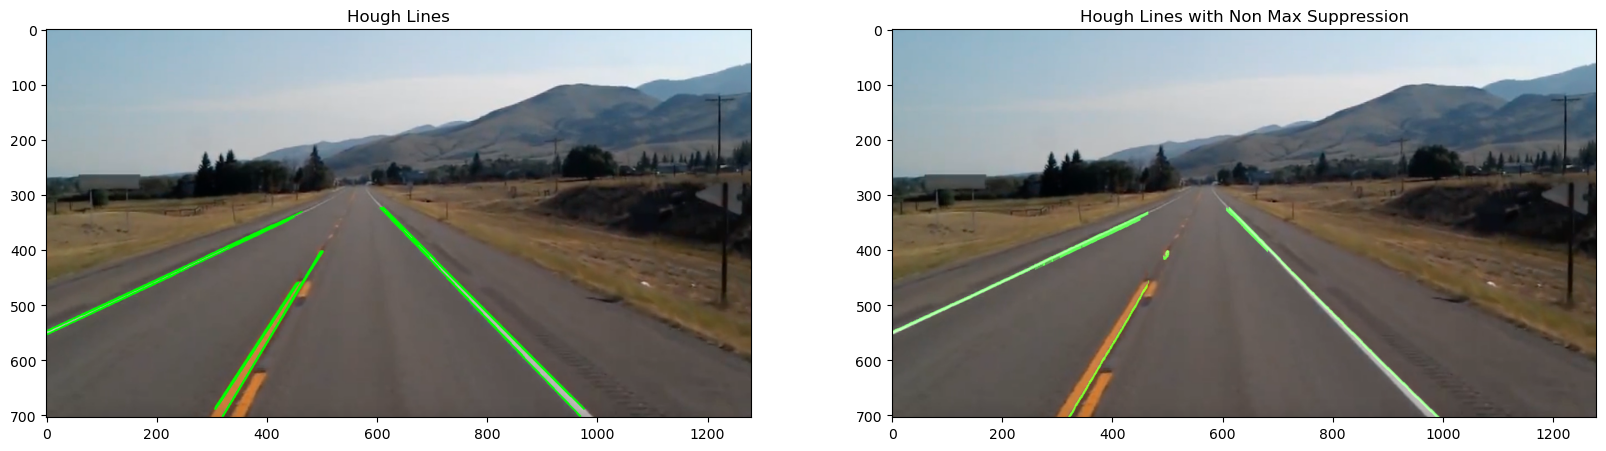

In [17]:
for line in line_coords:
    x1, y1, x2, y2 = line[0]
    cv2.line(img1, (x1, y1), (x2, y2), (0, 255, 0), 2)

plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.imshow(img1)
plt.title('Hough Lines')

plt.subplot(1,2,2)
plt.imshow(overlay)
plt.title('Hough Lines with Non Max Suppression')

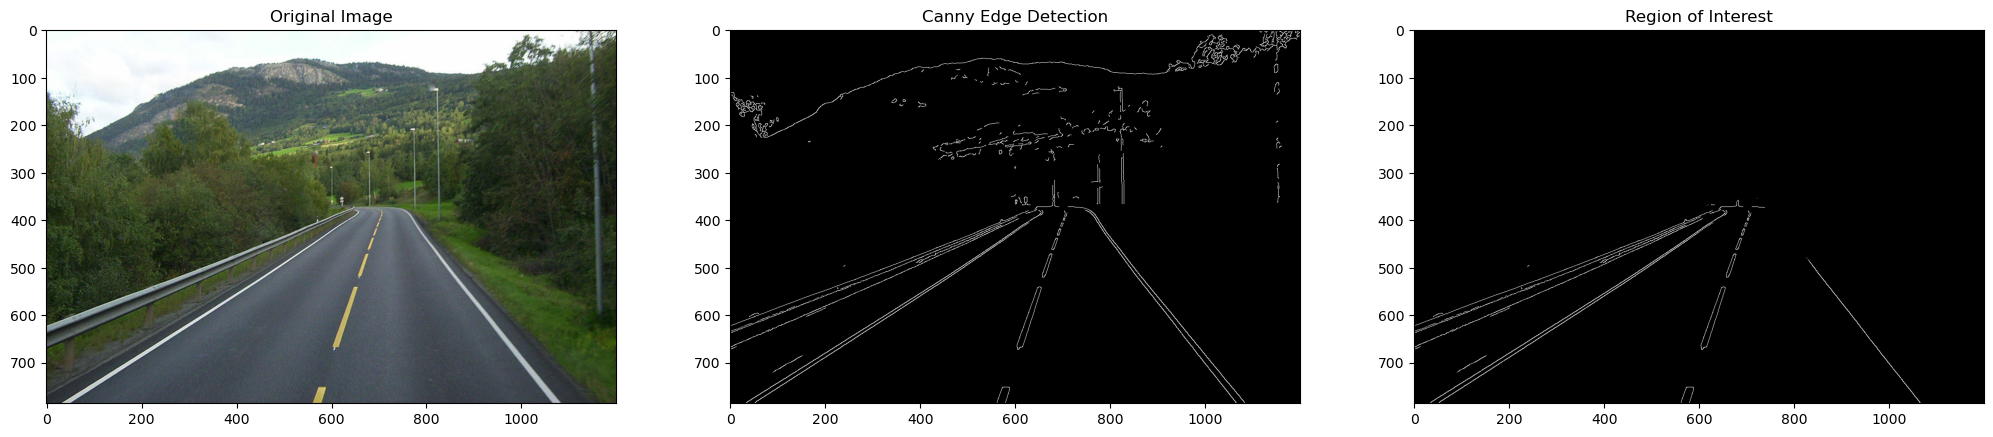

Text(0.5, 1.0, 'Hough Lines with Non Max Suppression')

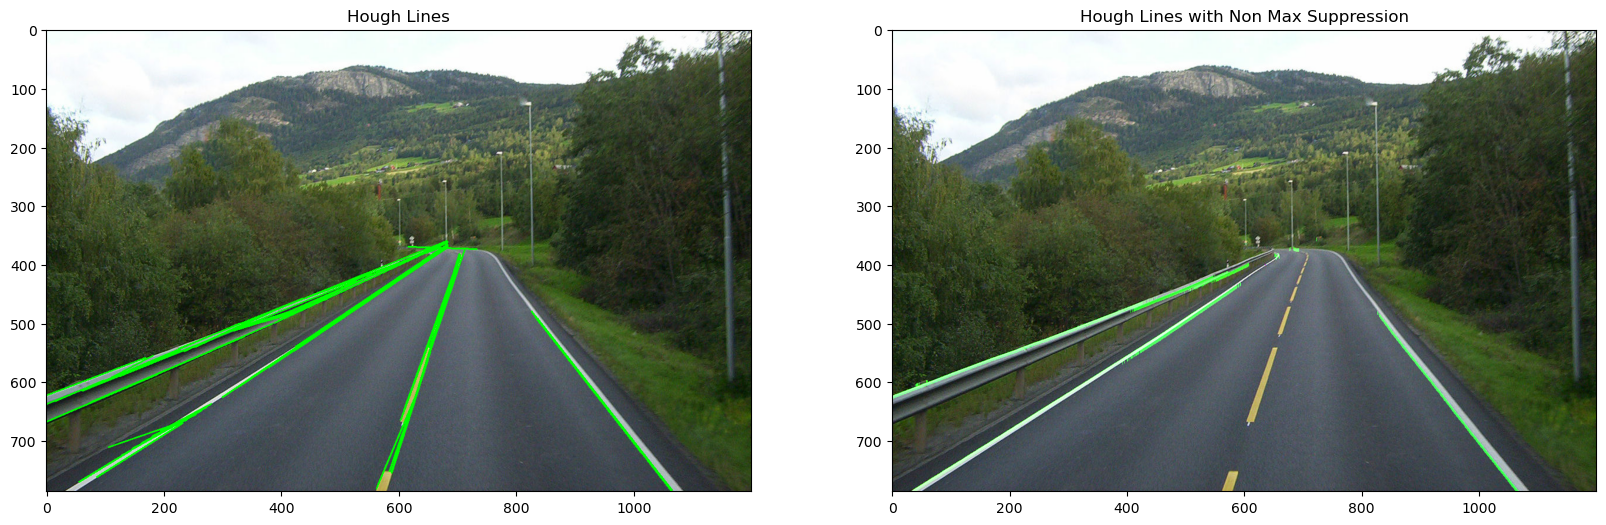

In [21]:
img = cv2.cvtColor(cv2.imread('Lanes/lane_3.jpg'),cv2.COLOR_BGR2RGB)
img1=img.copy()
img2=img.copy()

plt.figure(figsize=(25,10))
plt.subplot(1,3,1)
plt.imshow(img)
plt.title('Original Image')

canny = find_edges(img,100,170)
plt.subplot(1,3,2)
plt.imshow(canny, cmap='gray')
plt.title('Canny Edge Detection')

roi_img = roi(canny,tl=0.6)
plt.subplot(1,3,3)
plt.imshow(roi_img, cmap='gray')
plt.title('Region of Interest')
plt.show()


line_coords, polar_params = hough_transform(roi_img)
filtered_lines = non_max_suppression(polar_params,30, 5,3)
ht_mask = cv2.cvtColor(roi_img, cv2.COLOR_GRAY2RGB)
mask_lines = np.zeros(img.shape, dtype="uint8")
for line in filtered_lines:
    rho, theta = line
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a * rho
    y0 = b * rho
    
    x1 = int(x0 + 2000 * (-b))  
    y1 = int(y0 + 2000 * (a))
    x2 = int(x0 - 2000 * (-b))
    y2 = int(y0 - 2000 * (a))
    
    cv2.line(mask_lines, (x1,y1), (x2,y2), [0,255,0], 5)

mask_output = cv2.bitwise_and(mask_lines, mask_lines, mask=ht_mask[:,:,-1])
dilated_mask = cv2.dilate(mask_output, (5,5), iterations=5)
overlay = cv2.addWeighted(img2, 1, dilated_mask, 1, 0)

for line in line_coords:
    x1, y1, x2, y2 = line[0]
    cv2.line(img1, (x1, y1), (x2, y2), (0, 255, 0), 2)

plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.imshow(img1)
plt.title('Hough Lines')

plt.subplot(1,2,2)
plt.imshow(overlay)
plt.title('Hough Lines with Non Max Suppression')


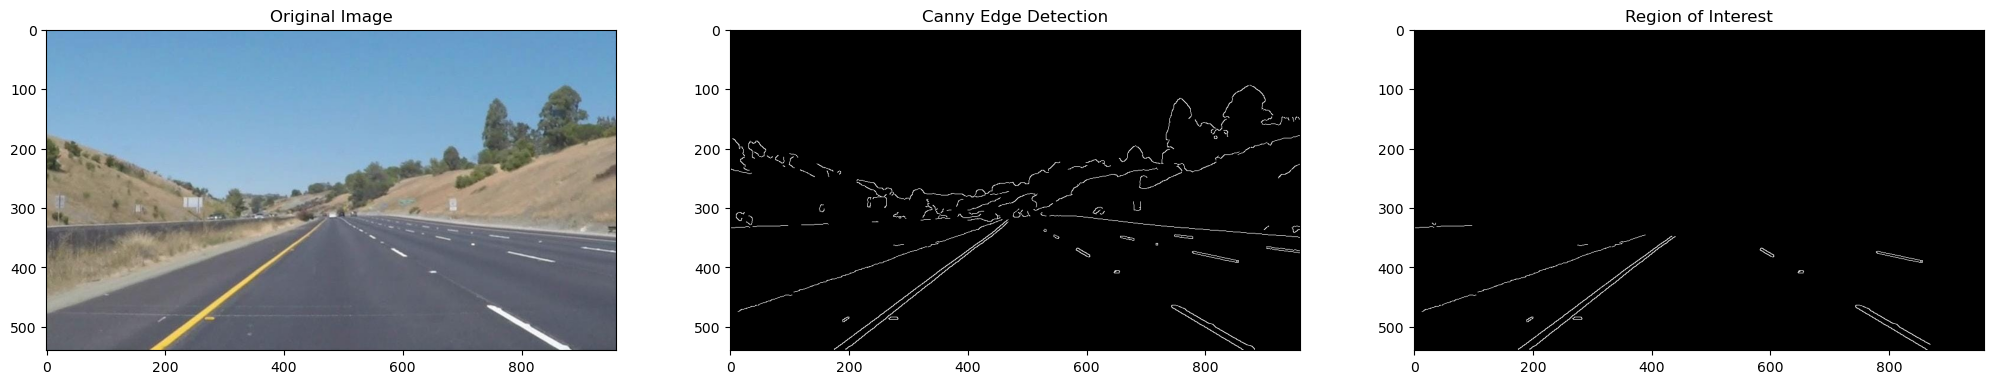

Text(0.5, 1.0, 'Hough Lines with Non Max Suppression')

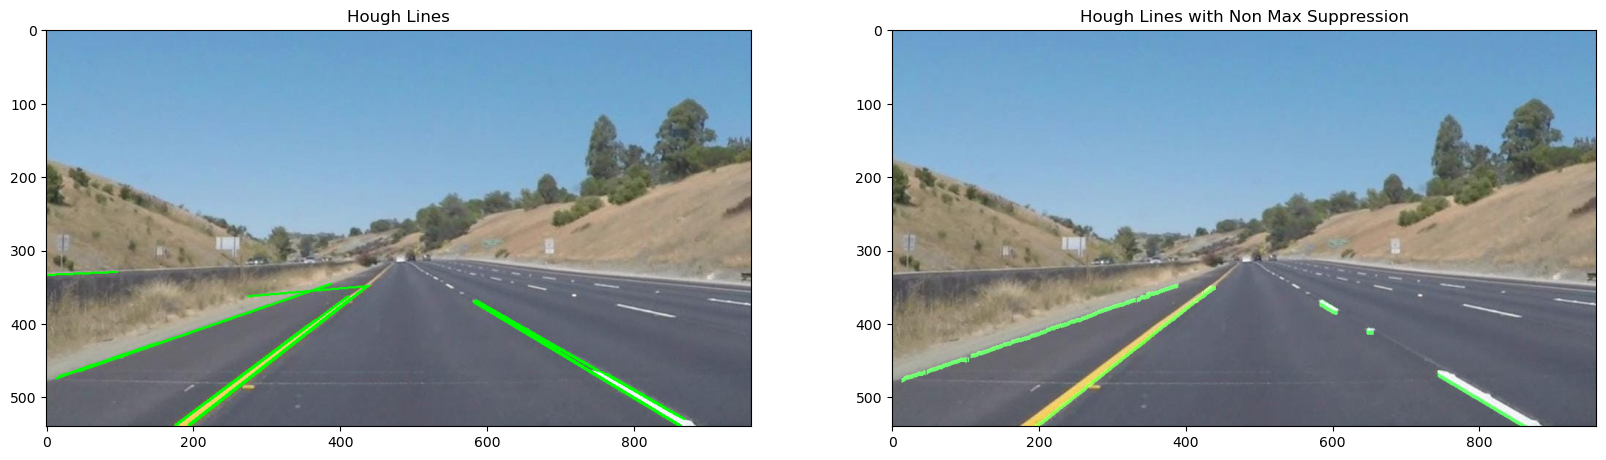

In [22]:
img = cv2.cvtColor(cv2.imread('Lanes/lane_2.jpg'),cv2.COLOR_BGR2RGB)
img1=img.copy()
img2=img.copy()

plt.figure(figsize=(25,10))
plt.subplot(1,3,1)
plt.imshow(img)
plt.title('Original Image')

canny = find_edges(img,100,170)
plt.subplot(1,3,2)
plt.imshow(canny, cmap='gray')
plt.title('Canny Edge Detection')

roi_img = roi(canny,tl=0.6,tr=(1,0.7))
plt.subplot(1,3,3)
plt.imshow(roi_img, cmap='gray')
plt.title('Region of Interest')
plt.show()


line_coords, polar_params = hough_transform(roi_img)
filtered_lines = non_max_suppression(polar_params,30, 5,3)
ht_mask = cv2.cvtColor(roi_img, cv2.COLOR_GRAY2RGB)
mask_lines = np.zeros(img.shape, dtype="uint8")
for line in filtered_lines:
    rho, theta = line
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a * rho
    y0 = b * rho
    
    x1 = int(x0 + 2000 * (-b))  
    y1 = int(y0 + 2000 * (a))
    x2 = int(x0 - 2000 * (-b))
    y2 = int(y0 - 2000 * (a))
    
    cv2.line(mask_lines, (x1,y1), (x2,y2), [0,255,0], 5)

mask_output = cv2.bitwise_and(mask_lines, mask_lines, mask=ht_mask[:,:,-1])
dilated_mask = cv2.dilate(mask_output, (5,5), iterations=5)
overlay = cv2.addWeighted(img2, 1, dilated_mask, 1, 0)

for line in line_coords:
    x1, y1, x2, y2 = line[0]
    cv2.line(img1, (x1, y1), (x2, y2), (0, 255, 0), 2)

plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.imshow(img1)
plt.title('Hough Lines')

plt.subplot(1,2,2)
plt.imshow(overlay)
plt.title('Hough Lines with Non Max Suppression')